In [1]:
import os

import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import pooch

from fair import FAIR
from fair.io import read_properties
from fair.interface import fill, initialise
from fair.earth_params import seconds_per_year # Don't really neeed this

## Initialise FaIR and define time horizon
1. Makes a FaIR object and the methane life time method. Version 2 uses the version from Nick Leaches paper.
   By default this is the one that is used but you can specify it if you put 'leach2021' in here.
2. By using 'thornhill2021' we are using the version with interactive methane lifetime. 

In [2]:
import fair
fair.__version__

'2.2.0'

In [3]:
f = FAIR()

In [4]:
f.ch4_method='thornhill2021'

In [5]:
help(f.define_time)

Help on method define_time in module fair.fair:

define_time(start, end, step) method of fair.fair.FAIR instance
    Define timebounds vector to run FaIR.
    
    Parameters
    ----------
    start : float
        first timebound of the model (year)
    end : float
        last timebound of the model (year)
    step : float
        timestep (year)



In [6]:
f.define_time(1750, 2500, 1)

## 2. Define scenarios
   Focusing on 4 of the SSPs; important that the names are consistent with those in the RCMIP database

In [7]:
# Define SSP scenarios
#scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp460', 'ssp534-over', 'ssp585']
scenarios = [ 'ssp126', 'ssp245', 'ssp370', 'ssp585']
f.define_scenarios(scenarios)
print (f.scenarios)

['ssp126', 'ssp245', 'ssp370', 'ssp585']


## 3. Define configs 
   Here we are using the AR6 defined ones specified in 1.4.0

In [8]:
df_configs = pd.read_csv('../data/fair-parameters/calibration-AR6/calibrated_constrained_parameters_1.4.0.csv', index_col=0)

In [9]:
f.define_configs(df_configs.index)

## 4. Define species and properties 

In [10]:
species, properties = read_properties('../data/fair-parameters/calibration-AR6/species_configs_properties_1.4.0.csv')
f.define_species(species, properties)

## 5. Create input and output data

In [11]:
f.allocate()

## 6. Fill in the data

    we read in a default list of species configs that will apply to each config. If you want to change specific configs then you can still use this function to set defaults and tweak what you need. We will do this with the methane lifetime, which has a different value calibrated for the Thornhill 2021 lifetime option.

Also going to subtract the RCMIP 1750 emissions from CH4 and N2O. This is not in the default configs.

In [12]:
f.fill_species_configs()
fill(f.species_configs['unperturbed_lifetime'], 10.8537568, specie='CH4')
fill(f.species_configs['baseline_emissions'], 19.01978312, specie='CH4')
fill(f.species_configs['baseline_emissions'], 0.08602230754, specie='N2O')

## 6a. Now get emissions

 emissions (+solar and volcanic forcing) from RCMIP datasets using the fill_from_rcmip helper function. This function automatically selects the emissions, concentration or forcing you want depending on the properties for each of the SSP scenarios defined.

Replace the volcanic dataset with the AR6 volcanic dataset, as I want to compare the impact of monthly volcanic forcing in the monthly comparison.


You can modify the input_mode to be concentrations if you don't have all the gases as emissions. 
You have to have both fossil emissions and AFOLU emissions to run in emissions mode. 

The following creates xarrays that you need. so running f.emissions now will return the empty arrays prepared for running FaIR. 

In [13]:
volcanic_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-calibrate/main/data/forcing/volcanic_ERF_1750-2101_timebounds.csv',
    known_hash = 'md5:c0801f80f70195eb9567dbd70359219d',
)

In [14]:
solar_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-add-hfc/main/data/solar_erf_timebounds.csv',
    known_hash = 'md5:98f6f4c5309d848fea89803683441acf',
)

In [15]:
df_solar = pd.read_csv(solar_obj, index_col="year")
df_volcanic = pd.read_csv(volcanic_obj)

In [16]:
print(df_volcanic)
print(df_solar)

     timebounds       erf
0          1750  0.246391
1          1751  0.246412
2          1752  0.246420
3          1753  0.246422
4          1754  0.246423
..          ...       ...
347        2097  0.000000
348        2098  0.000000
349        2099  0.000000
350        2100  0.000000
351        2101  0.000000

[352 rows x 2 columns]
           erf
year          
1750  0.102215
1751  0.097800
1752  0.079454
1753  0.049376
1754  0.013198
...        ...
2296 -0.004042
2297  0.019260
2298  0.044293
2299  0.044941
2300  0.025859

[551 rows x 1 columns]


In [17]:
f.emissions

<xarray.DataArray (timepoints: 750, scenario: 4, config: 841, specie: 61)> Size: 1GB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], shape=(750, 4, 841, 61))
Coordinates:
  * timepoints  (timepoints) float64 6kB 1.75e+03 1.752e+03 ... 2.5e+03
  * scenario    (scenario) <U6 96B 'ssp126' 'ssp245' 'ssp370' 'ssp585'
  * config      (config) int64 7kB 2463 2658 4204 ... 1595003 1595963 1597740
  * specie      (specie) <U43 10kB 'CO2 FFI' ... 'Equivalent effective strato...

Read_properties is imported at the beginning, takes list of default species and properties including GHGs, shortlived forcing and anything you want to calculate and anything you want to calculate a forcing for (so any of the 40 species and things like aerosol cloud forcing).

Read in RCMIP emissions from zenodo stores it in cache and populates the emissions with rcmip data. 

In [18]:
f.fill_from_rcmip()

In [19]:
f.configs

Index([   2463,    2658,    4204,    4743,    6941,    7267,    9765,   10917,
         13465,   14044,
       ...
       1583204, 1584567, 1584895, 1588527, 1589426, 1592375, 1593438, 1595003,
       1595963, 1597740],
      dtype='int64', length=841)

Running f.emissions should not be empty anymore

In [20]:
f.emissions

<xarray.DataArray (timepoints: 750, scenario: 4, config: 841, specie: 61)> Size: 1GB
array([[[[0.00950562, 0.29746461,        nan, ...,        nan,
                 nan,        nan],
         [0.00950562, 0.29746461,        nan, ...,        nan,
                 nan,        nan],
         [0.00950562, 0.29746461,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [0.00950562, 0.29746461,        nan, ...,        nan,
                 nan,        nan],
         [0.00950562, 0.29746461,        nan, ...,        nan,
                 nan,        nan],
         [0.00950562, 0.29746461,        nan, ...,        nan,
                 nan,        nan]],

        [[0.00950562, 0.29746461,        nan, ...,        nan,
                 nan,        nan],
         [0.00950562, 0.29746461,        nan, ...,        nan,
                 nan,        nan],
         [0.00950562, 0.29746461,        nan, ...,        nan,
                 nan,        nan],
...
         [0.        , 0.        ,        nan, ...,        nan,
                 nan,        nan],
         [0.        , 0.        ,        nan, ...,        nan,
                 nan,        nan],
         [0.        , 0.        ,        nan, ...,        nan,
                 nan,        nan]],

        [[0.        , 0.        ,        nan, ...,        nan,
                 nan,        nan],
         [0.        , 0.        ,        nan, ...,        nan,
                 nan,        nan],
         [0.        , 0.        ,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [0.        , 0.        ,        nan, ...,        nan,
                 nan,        nan],
         [0.        , 0.        ,        nan, ...,        nan,
                 nan,        nan],
         [0.        , 0.        ,        nan, ...,        nan,
                 nan,        nan]]]], shape=(750, 4, 841, 61))
Coordinates:
  * timepoints  (timepoints) float64 6kB 1.75e+03 1.752e+03 ... 2.5e+03
  * scenario    (scenario) <U6 96B 'ssp126' 'ssp245' 'ssp370' 'ssp585'
  * config      (config) int64 7kB 2463 2658 4204 ... 1595003 1595963 1597740
  * specie      (specie) <U43 10kB 'CO2 FFI' ... 'Equivalent effective strato...

We also need to initialise the first timestep of the run in terms of its per-species forcing, temperature, cumulative and airborne emissions. We set these all to zero. The concentration in the first timestep will be set to the baseline concentration, which are the IPCC AR6 1750 values.

In [21]:
initialise(f.concentration, f.species_configs['baseline_concentration'])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

We can define natural variability using stochastic_run if we want! We do this by using the code in the box below this next one.

Print out the species used here:

In [22]:
f.species

['CO2 FFI',
 'CO2 AFOLU',
 'CO2',
 'CH4',
 'N2O',
 'Sulfur',
 'BC',
 'OC',
 'NH3',
 'NOx',
 'VOC',
 'CO',
 'CFC-11',
 'CFC-12',
 'CFC-113',
 'CFC-114',
 'CFC-115',
 'HCFC-22',
 'HCFC-141b',
 'HCFC-142b',
 'CCl4',
 'CHCl3',
 'CH2Cl2',
 'CH3Cl',
 'CH3CCl3',
 'CH3Br',
 'Halon-1211',
 'Halon-1301',
 'Halon-2402',
 'CF4',
 'C2F6',
 'C3F8',
 'c-C4F8',
 'C4F10',
 'C5F12',
 'C6F14',
 'C7F16',
 'C8F18',
 'NF3',
 'SF6',
 'SO2F2',
 'HFC-125',
 'HFC-134a',
 'HFC-143a',
 'HFC-152a',
 'HFC-227ea',
 'HFC-23',
 'HFC-236fa',
 'HFC-245fa',
 'HFC-32',
 'HFC-365mfc',
 'HFC-4310mee',
 'Solar',
 'Volcanic',
 'Aerosol-radiation interactions',
 'Aerosol-cloud interactions',
 'Ozone',
 'Light absorbing particles on snow and ice',
 'Stratospheric water vapour',
 'Land use',
 'Equivalent effective stratospheric chlorine']

## 7c. fill climate configs¶

In the example Chris uses pre-calculated values from the Cummins et al. three layer model and use a reproducible random seed to define the stochastic behaviour as below.

        df = pd.read_csv("../tests/test_data/4xCO2_cummins_ebm3.csv")
        models = df['model'].unique()
        
        seed = 1355763
        
        for config in configs:
            model, run = config.split('_')
            condition = (df['model']==model) & (df['run']==run)
            fill(f.climate_configs['ocean_heat_capacity'], df.loc[condition, 'C1':'C3'].values.squeeze(), config=config)
            fill(f.climate_configs['ocean_heat_transfer'], df.loc[condition, 'kappa1':'kappa3'].values.squeeze(), config=config)
            fill(f.climate_configs['deep_ocean_efficacy'], df.loc[condition, 'epsilon'].values[0], config=config)
            fill(f.climate_configs['gamma_autocorrelation'], df.loc[condition, 'gamma'].values[0], config=config)
            fill(f.climate_configs['sigma_eta'], df.loc[condition, 'sigma_eta'].values[0], config=config)
            fill(f.climate_configs['sigma_xi'], df.loc[condition, 'sigma_xi'].values[0], config=config)
            fill(f.climate_configs['stochastic_run'], True, config=config)
            fill(f.climate_configs['use_seed'], True, config=config)
            fill(f.climate_configs['seed'], seed, config=config)
            
            seed = seed + 399

However I thought that the configs should be in the 1.4.0 files which are in ../data/fair-parameters/calibration-AR6/calibrated_constrained_parameters_1.4.0.csv

 Printing out the configs using df_configs looks like it has the right stuff in it.

In [23]:
# camilla, u need this line
f.override_defaults('../data/fair-parameters/calibration-AR6/calibrated_constrained_parameters_1.4.0.csv')

In [24]:
f.run()

Running 3364 projections in parallel:   0%|          | 0/750 [00:00<?, ?timesteps/s]

Text(0, 0.5, 'Temperature anomaly (K)')

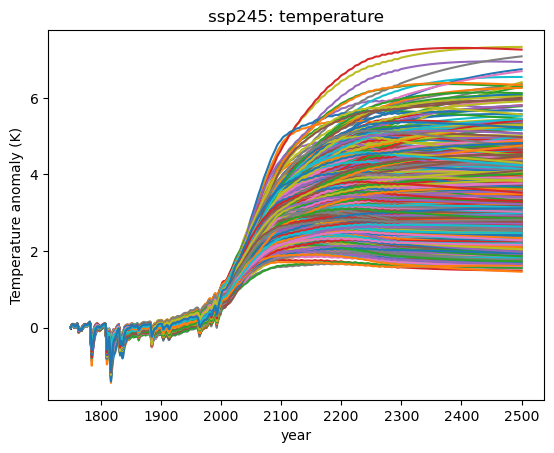

In [25]:
pl.plot(f.timebounds, f.temperature.loc[dict(scenario='ssp245', layer=0)], label=f.configs);
pl.title('ssp245: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')

In [26]:
dir(f)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_aci_indices',
 '_aerosol_chemistry_from_concentration_indices',
 '_aerosol_chemistry_from_emissions_indices',
 '_ari_indices',
 '_aviation_nox_indices',
 '_bc_indices',
 '_cfc11_indices',
 '_ch4_indices',
 '_ch4_method',
 '_check_properties',
 '_co2_afolu_indices',
 '_co2_ffi_indices',
 '_co2_indices',
 '_contrails_indices',
 '_eesc_indices',
 '_ghg_forward_indices',
 '_ghg_indices',
 '_ghg_inverse_indices',
 '_ghg_method',
 '_h2ostrat_indices',
 '_halogen_indices',
 '_landuse_indices',
 '_lapsi_indices',
 '_make_ebms',
 '_make_indices',
 '_minor_ghg_indices',
 '_n2o_indices',
 '_n_configs',
 '_n_gasbox

Defining time in emissions you need to remember to go from the midpoint of the year you are interested in, so go 2015.5 to get 2015.

In [27]:
f.emissions.loc[
    dict(
        scenario='ssp245', 
        specie='CH4', 
        timepoints=np.arange(2015.5, 2500.5)
    )
]

<xarray.DataArray (timepoints: 485, config: 841)> Size: 3MB
array([[388.07279566, 388.07279566, 388.07279566, ..., 388.07279566,
        388.07279566, 388.07279566],
       [388.07635106, 388.07635106, 388.07635106, ..., 388.07635106,
        388.07635106, 388.07635106],
       [388.07990646, 388.07990646, 388.07990646, ..., 388.07990646,
        388.07990646, 388.07990646],
       ...,
       [122.10259461, 122.10259461, 122.10259461, ..., 122.10259461,
        122.10259461, 122.10259461],
       [122.10259461, 122.10259461, 122.10259461, ..., 122.10259461,
        122.10259461, 122.10259461],
       [122.10259461, 122.10259461, 122.10259461, ..., 122.10259461,
        122.10259461, 122.10259461]], shape=(485, 841))
Coordinates:
  * timepoints  (timepoints) float64 4kB 2.016e+03 2.016e+03 ... 2.5e+03
    scenario    <U6 24B 'ssp245'
  * config      (config) int64 7kB 2463 2658 4204 ... 1595003 1595963 1597740
    specie      <U43 172B 'CH4'

In [28]:
f.emissions.loc[
    dict(
        scenario='ssp245', 
        specie='CH4', 
        timepoints=np.arange(2015.5, 2500.5)
    )
]=0.2*f.emissions.loc[
    dict(
        scenario='ssp245', 
        specie='CH4', 
        timepoints=np.arange(2015.5, 2500.5)
    )
]

In [29]:
f.emissions.loc[
    dict(
        scenario='ssp245', 
        specie='CH4', 
        timepoints=np.arange(2015.5, 2500.5)
    )
]

<xarray.DataArray (timepoints: 485, config: 841)> Size: 3MB
array([[77.61455913, 77.61455913, 77.61455913, ..., 77.61455913,
        77.61455913, 77.61455913],
       [77.61527021, 77.61527021, 77.61527021, ..., 77.61527021,
        77.61527021, 77.61527021],
       [77.61598129, 77.61598129, 77.61598129, ..., 77.61598129,
        77.61598129, 77.61598129],
       ...,
       [24.42051892, 24.42051892, 24.42051892, ..., 24.42051892,
        24.42051892, 24.42051892],
       [24.42051892, 24.42051892, 24.42051892, ..., 24.42051892,
        24.42051892, 24.42051892],
       [24.42051892, 24.42051892, 24.42051892, ..., 24.42051892,
        24.42051892, 24.42051892]], shape=(485, 841))
Coordinates:
  * timepoints  (timepoints) float64 4kB 2.016e+03 2.016e+03 ... 2.5e+03
    scenario    <U6 24B 'ssp245'
  * config      (config) int64 7kB 2463 2658 4204 ... 1595003 1595963 1597740
    specie      <U43 172B 'CH4'

In [30]:
print(f.ocean_heat_content_change.loc[dict(scenario='ssp245', timebounds=np.arange(1750, 2500))])

<xarray.DataArray (timebounds: 750, config: 841)> Size: 5MB
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.62243047e+21, 2.97811484e+21, 3.58398162e+21, ...,
        3.57606124e+21, 3.27732823e+21, 3.53652211e+21],
       [6.55469320e+21, 5.32243850e+21, 6.29398439e+21, ...,
        6.31667794e+21, 5.86177949e+21, 6.39191905e+21],
       ...,
       [6.88771494e+24, 5.95158710e+24, 3.90228983e+24, ...,
        3.53213022e+24, 4.63424541e+24, 7.05325719e+24],
       [6.89005229e+24, 5.95656246e+24, 3.90212041e+24, ...,
        3.53153163e+24, 4.63490579e+24, 7.05620005e+24],
       [6.89237023e+24, 5.96152161e+24, 3.90194532e+24, ...,
        3.53093187e+24, 4.63555664e+24, 7.05912472e+24]], shape=(750, 841))
Coordinates:
  * timebounds  (timebounds) float64 6kB 1.75e+03 1.751e+03 ... 2.499e+03
    scenario    <U6 24B 'ssp245'
  * config      (config) int64 7kB 2463 2658 4204 ... 1595003 1595963 1597740


In [31]:
print(f.temperature.loc[dict(scenario='ssp245', timebounds=np.arange(1750, 2500))])

<xarray.DataArray (timebounds: 750, config: 841, layer: 3)> Size: 15MB
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[2.54205096e-02, 4.32954314e-04, 1.75268461e-06],
        [3.67284345e-02, 3.38364375e-03, 3.85103973e-06],
        [2.00959667e-02, 8.72951875e-04, 8.85293715e-06],
        ...,
        [2.26388236e-02, 1.75054115e-03, 2.32179715e-05],
        [3.46161075e-02, 2.58220379e-03, 1.03266533e-05],
        [3.61795933e-02, 4.21949743e-03, 1.65562421e-05]],

       [[5.76079656e-02, 2.20973828e-03, 1.94523571e-05],
        [4.95250481e-02, 1.00946443e-02, 2.62246247e-05],
        [4.08022671e-02, 3.80717257e-03, 8.64999155e-05],
        ...,
...
        [3.8

In [32]:
# Output to csv, first create a dataframe 
model_archive = '../csv_FaIRoutputfiles_ssp/'
print (scenarios)
print 

if os.path.isdir(model_archive):
    print("Item already exists")
else:
    os.mkdir(model_archive)
    print ("Making the model directory")
    
#model_dir = model_archive+scenario+'/'
    
for scenario in scenarios:
    for variable in ['ocean_heat_content_change', 'temperature']:
    
        years = 1750+np.arange(len(f.temperature.loc[dict(scenario=scenario, timebounds=np.arange(1750, 2501))]))
        header_text = np.insert(years, 0, 0)
        if variable == 'ocean_heat_content_change':
            dic = f.ocean_heat_content_change.loc[dict(scenario=scenario, timebounds=np.arange(1750, 2501))]
        else:
            dic = f.temperature.loc[dict(scenario=scenario, timebounds=np.arange(1750, 2501), layer=0)]
        
        SSPs = {'ssp119':'ssp119',
                'ssp126':'ssp126',
                'ssp245':'ssp245',
                'ssp370':'ssp370',
                'ssp534-over':'ssp534_over', 
                'ssp585':'ssp585'
          }
        
        filename='../csv_FaIRoutputfiles_ssp/ssprcmip_'+SSPs[scenario]+'_'+variable+'.csv'
        print(filename)
        pd.DataFrame(dic).T.reset_index().to_csv(filename, header=header_text, index=False)
        

['ssp126', 'ssp245', 'ssp370', 'ssp585']
Item already exists
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp126_ocean_heat_content_change.csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp126_temperature.csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp245_ocean_heat_content_change.csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp245_temperature.csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp370_ocean_heat_content_change.csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp370_temperature.csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp585_ocean_heat_content_change.csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp585_temperature.csv


Text(0, 0.5, 'Temperature anomaly (K)')

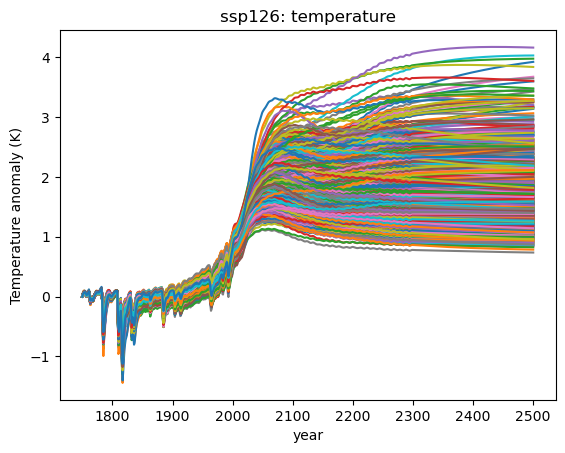

In [33]:
pl.plot(f.timebounds, f.temperature.loc[dict(scenario='ssp126', layer=0)], label=f.configs);
pl.title('ssp126: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')

Text(0, 0.5, 'Temperature anomaly (K)')

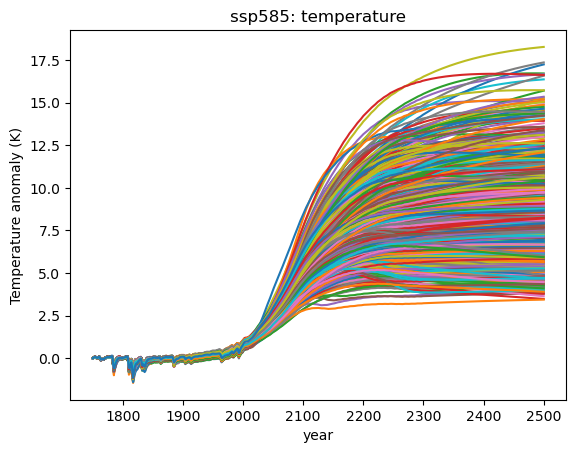

In [34]:
pl.plot(f.timebounds, f.temperature.loc[dict(scenario='ssp585', layer=0)], label=f.configs);
pl.title('ssp585: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')

Text(0, 0.5, 'J')

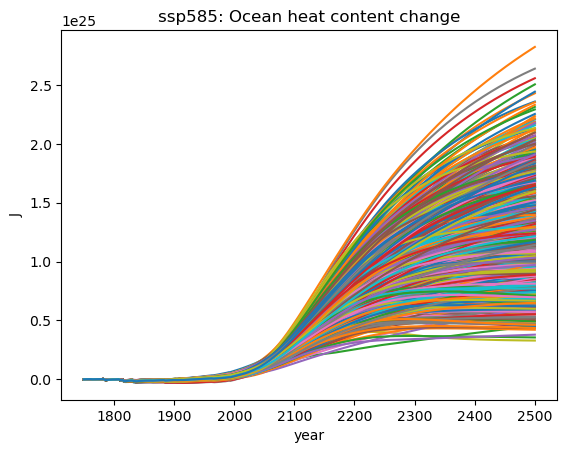

In [35]:
pl.plot(f.timebounds, f.ocean_heat_content_change.loc[dict(scenario='ssp585')], label=f.configs);
pl.title('ssp585: Ocean heat content change')
pl.xlabel('year')
pl.ylabel('J')


Text(0, 0.5, 'J')

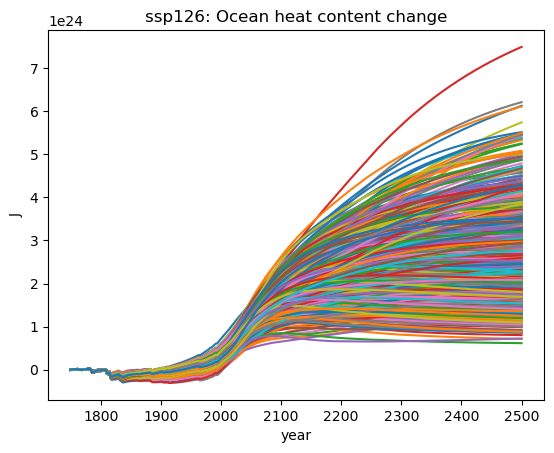

In [36]:
pl.plot(f.timebounds, f.ocean_heat_content_change.loc[dict(scenario='ssp126')], label=f.configs);
pl.title('ssp126: Ocean heat content change')
pl.xlabel('year')
pl.ylabel('J')

/var/tmp/ipykernel_145837/3256149812.py:2: MatplotlibDeprecationWarning: Passing label as a length 841 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  pl.plot(f.timebounds[:352], np.percentile(f.temperature.loc[dict(scenario='ssp585', layer=0)],perc, axis=1)[:352], label=f.configs)


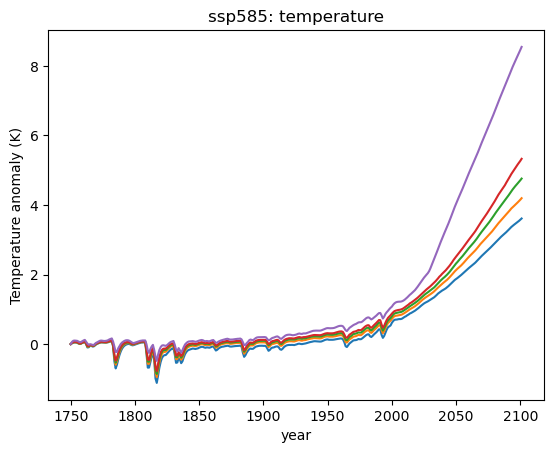

In [37]:
for perc in [5,25,50,75,100]:
    pl.plot(f.timebounds[:352], np.percentile(f.temperature.loc[dict(scenario='ssp585', layer=0)],perc, axis=1)[:352], label=f.configs)
    pl.title('ssp585: temperature')
    pl.xlabel('year')
    pl.ylabel('Temperature anomaly (K)')
    

/var/tmp/ipykernel_145837/4025824697.py:2: MatplotlibDeprecationWarning: Passing label as a length 841 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  pl.plot(f.timebounds[:352], np.percentile(f.temperature.loc[dict(scenario='ssp245', layer=0)],perc, axis=1)[:352], label=f.configs)


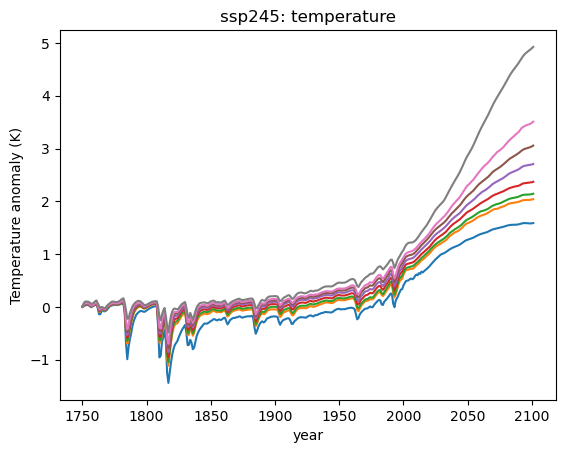

In [38]:
for perc in [0, 5,10,25,50,75,90,100]:
    pl.plot(f.timebounds[:352], np.percentile(f.temperature.loc[dict(scenario='ssp245', layer=0)],perc, axis=1)[:352], label=f.configs)
    pl.title('ssp245: temperature')
    pl.xlabel('year')
    pl.ylabel('Temperature anomaly (K)')

/var/tmp/ipykernel_145837/4075044248.py:2: MatplotlibDeprecationWarning: Passing label as a length 841 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  pl.plot(f.timebounds[:352], np.percentile(f.temperature.loc[dict(scenario='ssp370', layer=0)],perc, axis=1)[:352], label=f.configs)


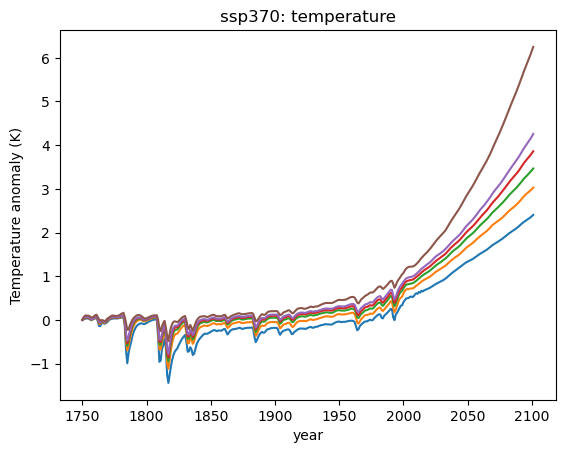

In [39]:
for perc in [0, 5,25,50,75,100]:
    pl.plot(f.timebounds[:352], np.percentile(f.temperature.loc[dict(scenario='ssp370', layer=0)],perc, axis=1)[:352], label=f.configs)
    pl.title('ssp370: temperature')
    pl.xlabel('year')
    pl.ylabel('Temperature anomaly (K)')

In [40]:
print(f.timebounds[270],f.temperature.loc[dict(scenario='ssp370', layer=0)][270])

2020.0 <xarray.DataArray (config: 841)> Size: 7kB
array([1.17911542, 1.18689815, 1.32060233, 1.27750673, 1.28422511,
       1.33748285, 1.33870999, 0.95779368, 1.13734986, 1.16636639,
       0.91902452, 1.20581434, 1.18984933, 1.172088  , 1.20984916,
       1.10012792, 1.11434632, 1.14262642, 1.09836561, 1.20737694,
       1.11872048, 1.27913923, 1.37779769, 1.50150717, 1.00976939,
       1.17553483, 1.26952492, 0.90504172, 1.05556124, 1.3585634 ,
       1.25665704, 1.4369708 , 1.35601695, 1.28703765, 1.27279121,
       1.41111665, 1.12809436, 1.34003066, 1.19447191, 1.3125882 ,
       1.29951708, 1.22305458, 1.25203001, 1.16404988, 1.11686751,
       1.24711745, 1.38138775, 0.97557554, 1.09575187, 1.20638792,
       1.09591248, 1.11944186, 1.35264252, 1.36205484, 1.20267291,
       0.98062003, 1.29062278, 0.85697215, 1.30644619, 1.32660783,
       1.2264797 , 1.18964055, 1.21690094, 1.14766663, 1.29113041,
       1.13570244, 1.25281587, 1.1075042 , 1.18695601, 0.8545411 ,
       1.339

# Requested output from FaIR
        * Temperatures - already output above
        * Ocean heat temperature change - already output above.
        
        * Emissions - these are rcmip so point to link although I can put into a csv file using f.emissions, 
        
        * Concentrations - f.concentration.loc[dict(scenario=scenario, specie='CH4')] or 'CO2' or whatever species
        * Radiative forcing -  f.forcing.loc[dict(scenario=scenario,specie='CH4')] or CO2 or whatever species
        
        * Airborne fraction
        

In [41]:
# Output to csv, first create a dataframe 
model_archive = '../csv_FaIRoutputfiles_ssp/'
print (scenarios)
print 

if os.path.isdir(model_archive):
    print("Item already exists")
else:
    os.mkdir(model_archive)
    print ("Making the model directory")
    
#model_dir = model_archive+scenario+'/'
    
for scenario in scenarios:
    for variable in ['forcing','concentration']:
        for specie in ['CH4', 'CO2', 'N2O']:
            years = 1750+np.arange(len(f.forcing.loc[dict(scenario=scenario, timebounds=np.arange(1750, 2501))]))
            header_text = np.insert(years, 0, 0)
            if variable == 'forcing':
                dic = f.forcing.loc[dict(scenario=scenario, specie=specie, timebounds=np.arange(1750, 2501))]
            else:
                dic = f.concentration.loc[dict(scenario=scenario,specie=specie, timebounds=np.arange(1750, 2501))]
        
                SSPs = {'ssp119':'ssp119',
                    'ssp126':'ssp126',
                    'ssp245':'ssp245',
                    'ssp370':'ssp370',
                    'ssp534-over':'ssp534_over', 
                    'ssp585':'ssp585'
                      }
        
                filename='../csv_FaIRoutputfiles_ssp/ssprcmip_'+SSPs[scenario]+'_'+variable+'_'+specie+'.csv'
                print(filename)
                pd.DataFrame(dic).T.reset_index().to_csv(filename, header=header_text, index=False)
        

['ssp126', 'ssp245', 'ssp370', 'ssp585']
Item already exists
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp126_concentration_CH4.csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp126_concentration_CO2.csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp126_concentration_N2O.csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp245_concentration_CH4.csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp245_concentration_CO2.csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp245_concentration_N2O.csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp370_concentration_CH4.csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp370_concentration_CO2.csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp370_concentration_N2O.csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp585_concentration_CH4.csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp585_concentration_CO2.csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp585_concentration_N2O.csv


Text(0, 0.5, 'Airborne CO$_2$ Fraction')

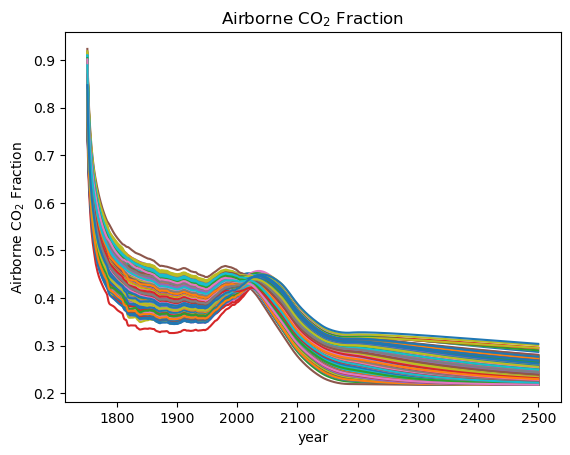

In [42]:
#print(f.airborne_fraction.sel(specie="CO2"))
#pl.plot(f.timebounds, f.ocean_heat_content_change.loc[dict(scenario='ssp126')], label=f.configs);
pl.plot(f.timebounds, f.airborne_fraction.loc[dict(scenario='ssp126', specie="CO2")], label=f.configs);
pl.title(r'Airborne CO$_2$ Fraction')
pl.xlabel('year')
pl.ylabel(r'Airborne CO$_2$ Fraction')


Text(0, 0.5, 'Airborne CO$_2$ Fraction')

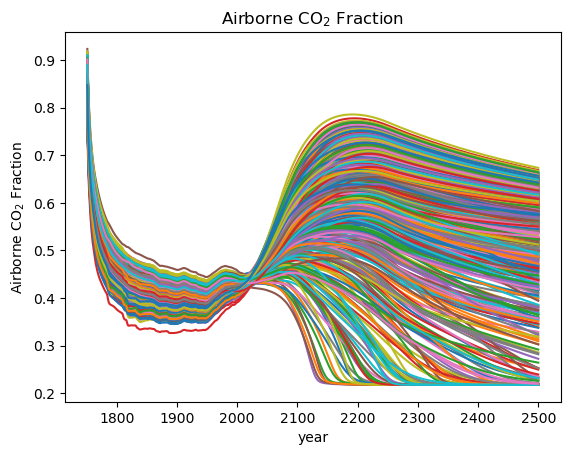

In [51]:
pl.plot(f.timebounds, f.airborne_fraction.loc[dict(scenario='ssp585', specie="CO2")], label=f.configs);
pl.title(r'Airborne CO$_2$ Fraction')
pl.xlabel('year')
pl.ylabel(r'Airborne CO$_2$ Fraction')


Text(0, 0.5, 'CO$_2$ Concentration')

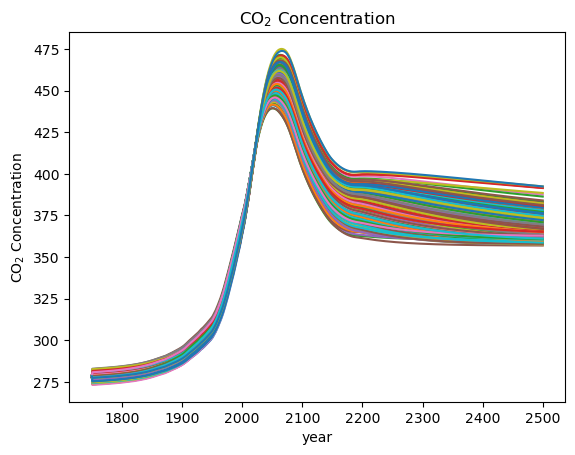

In [43]:
pl.plot(f.timebounds, f.concentration.loc[dict(scenario='ssp126', specie="CO2")], label=f.configs);
pl.title(r'CO$_2$ Concentration')
pl.xlabel('year')
pl.ylabel(r'CO$_2$ Concentration')


Text(0, 0.5, 'CO$_2$ Forcing W m$^-2$')

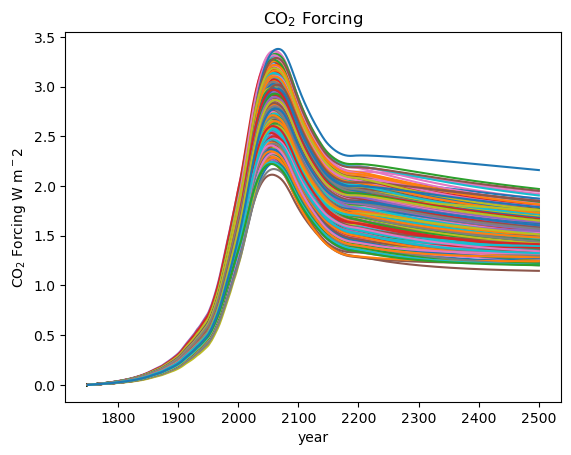

In [49]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp126', specie="CO2")], label=f.configs);
pl.title(r'CO$_2$ Forcing')
pl.xlabel('year')
pl.ylabel(r'CO$_2$ Forcing W m$^-2$')


Text(0, 0.5, 'CO$_2$ Forcing W m$^-2$')

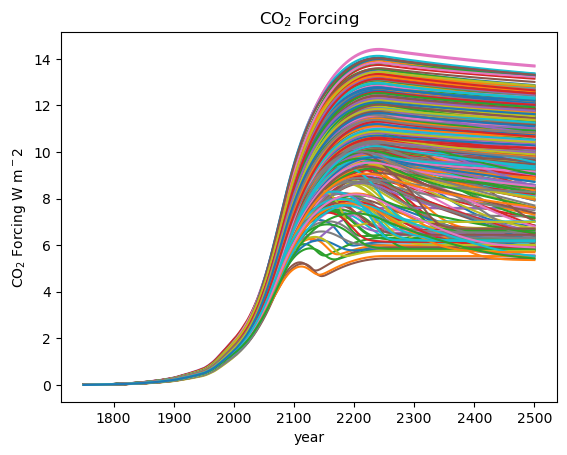

In [50]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp585', specie="CO2")], label=f.configs);
pl.title(r'CO$_2$ Forcing')
pl.xlabel('year')
pl.ylabel(r'CO$_2$ Forcing W m$^-2$')

Text(0, 0.5, 'CO$_2$ Concentration')

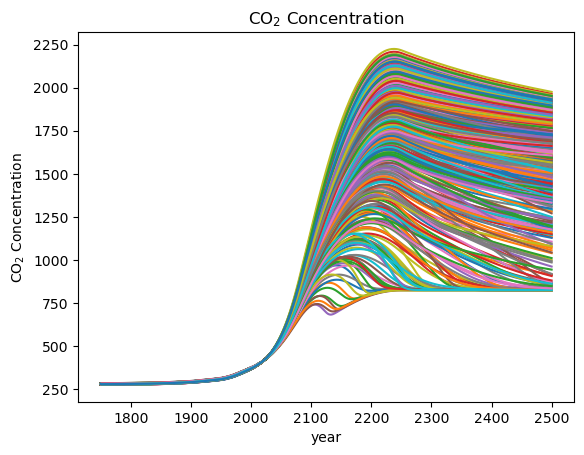

In [45]:
pl.plot(f.timebounds, f.concentration.loc[dict(scenario='ssp585', specie="CO2")], label=f.configs);
pl.title(r'CO$_2$ Concentration')
pl.xlabel('year')
pl.ylabel(r'CO$_2$ Concentration')

In [44]:
# Output to csv, first create a dataframe 
model_archive = '../csv_FaIRoutputfiles_ssp/'
print (scenarios)
print 

if os.path.isdir(model_archive):
    print("Item already exists")
else:
    os.mkdir(model_archive)
    print ("Making the model directory")
    
#model_dir = model_archive+scenario+'/'
    
for scenario in scenarios:
    years = 1750+np.arange(len(f.airborne_fraction.loc[dict(scenario=scenario, timebounds=np.arange(1750, 2501))]))
    header_text = np.insert(years, 0, 0)

    dic = f.airborne_fraction.loc[dict(scenario=scenario, specie="CO2", timebounds=np.arange(1750, 2501))]
    SSPs = {'ssp119':'ssp119',
                    'ssp126':'ssp126',
                    'ssp245':'ssp245',
                    'ssp370':'ssp370',
                    'ssp534-over':'ssp534_over', 
                    'ssp585':'ssp585'
                      }
        
    filename='../csv_FaIRoutputfiles_ssp/ssprcmip_'+SSPs[scenario]+'_CO2airbornefraction.csv'
    print(filename)
    pd.DataFrame(dic).T.reset_index().to_csv(filename, header=header_text, index=False)
        

['ssp126', 'ssp245', 'ssp370', 'ssp585']
Item already exists
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp126_CO2airbornefraction.csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp245_CO2airbornefraction.csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp370_CO2airbornefraction.csv
../csv_FaIRoutputfiles_ssp/ssprcmip_ssp585_CO2airbornefraction.csv
